# Anomaly Detection

This notebook shows some basic usage of CapyMOA for Anomaly Detection tasks.

Algorithms: `HalfSpaceTrees`, `Autoencoder` and `Online Isolation Forest`

Important notes: Prior to version 0.8.2, a lower anomaly score indicated a higher likelihood of an anomaly. This has been updated so that a higher anomaly score now indicates a higher likelihood of an anomaly, aligning with the standard anomaly detection literature.

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 10/01/2025**

## 1. Creating simple anomalous data with `sklearn`

* Generating a few examples and some simple anomalous data using `sklearn`

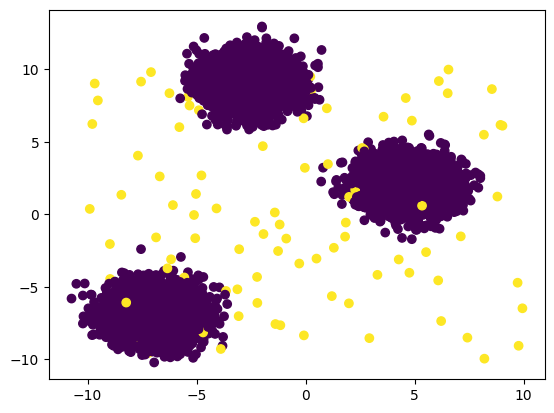

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream

# generate normal data points
n_samples = 10000
n_features = 2
n_clusters = 3
X, y = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
)

# generate anomalous data points
n_anomalies = 100  # the anomaly rate is 1%
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1] * n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

# shuffle the data
idx = np.random.permutation(n_samples + n_anomalies)
X = X[idx]
y = y[idx]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

## 2. Unsupervised Anomaly Detection for data streams

* Recent research has been focused on unsupervised anomaly detection for data streams, as it is often difficult to obtain labeled data for training.
* Instead of using evaluation functions, we first use a basic **test-then-train loop** from scratch to evaluate the model's performance.
* Please notice that higher scores indicate higher anomaly likelihood.

In [2]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import AnomalyDetectionEvaluator

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
learner = HalfSpaceTrees(stream_ad.get_schema())
evaluator = AnomalyDetectionEvaluator(stream_ad.get_schema())
while stream_ad.has_more_instances():
    instance = stream_ad.next_instance()
    score = learner.score_instance(instance)
    evaluator.update(instance.y_index, score)
    learner.train(instance)

auc = evaluator.auc()
print(f"AUC: {auc:.2f}")

AUC: 0.94


## 3. High-level evaluation functions

* CapyMOA provides `prequential_evaluation_anomaly` as a high level function to assess Anomaly Detectors


### 3.1 ```prequential_evaluation_anomaly```
In this example, we use the ```prequential_evaluation_anomaly``` function with ```plot_windowed_results``` to plot AUC for HalfSpaceTrees on the synthetic data stream

AUC: 0.9415815


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.849040,0.180372,0.060,-0.001022,0.000000,0.010101,0.215322,0.9,-93.000000
1,2000.0,0.945619,0.196099,0.007,0.000000,0.849040,0.007049,0.000000,1.0,-115.823529
2,3000.0,0.965010,0.215852,0.014,0.000000,0.945619,0.014199,0.000000,1.0,-94.419355
3,4000.0,0.927062,0.200816,0.006,0.000000,0.965010,0.006036,0.000000,1.0,-106.459459
4,5000.0,0.929814,0.185818,0.008,0.000000,0.927062,0.008065,0.000000,1.0,-109.222222
5,6000.0,0.944977,0.206376,0.013,0.000000,0.929814,0.013171,0.000000,1.0,-101.103448
6,7000.0,0.955576,0.207342,0.013,0.000000,0.944977,0.013171,0.000000,1.0,-96.309859
7,8000.0,0.972828,0.221292,0.010,0.000000,0.955576,0.010101,0.000000,1.0,-96.777778
8,9000.0,0.937626,0.216386,0.008,0.000000,0.972828,0.008065,0.000000,1.0,-99.314607
9,10000.0,0.976118,0.219181,0.009,0.000000,0.937626,0.009082,0.000000,1.0,-100.122449


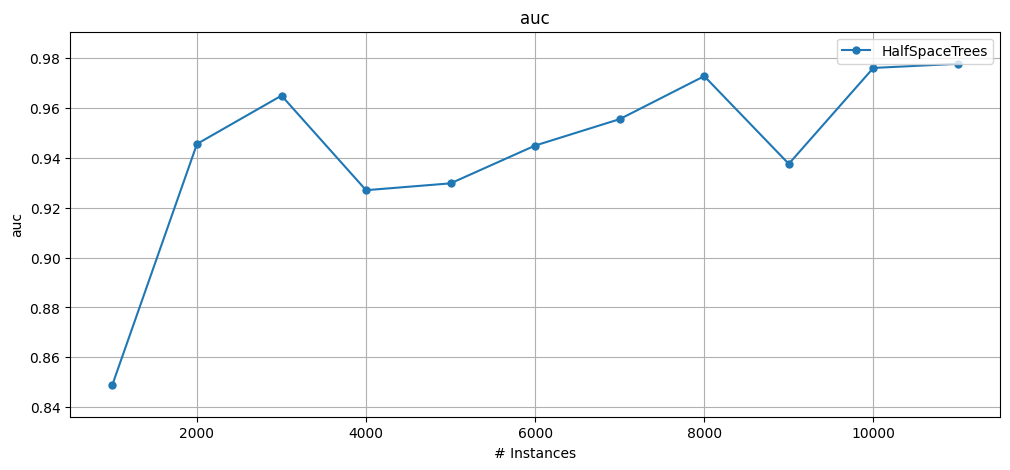

In [3]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
hst = HalfSpaceTrees(schema=stream_ad.get_schema())

results_hst = prequential_evaluation_anomaly(
    stream=stream_ad, learner=hst, window_size=1000
)

print(f"AUC: {results_hst.auc()}")
display(results_hst.windowed.metrics_per_window())
plot_windowed_results(results_hst, metric="auc", save_only=False)

## 3.2 Autoencoder

AUC: 0.54006


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.477778,0.015538,0.989,-0.001821,0.000000,0.010101,0.000000,0.0,-0.100000
1,2000.0,0.545533,0.028975,0.993,0.000000,0.477778,0.007049,0.000000,0.0,0.176471
2,3000.0,0.557664,0.000238,0.986,0.000000,0.545533,0.014199,0.000000,0.0,-0.354839
3,4000.0,0.615023,0.000008,0.994,0.000000,0.557664,0.006036,0.000000,0.0,0.351351
4,5000.0,0.523438,0.000445,0.991,-0.001781,0.615023,0.008065,0.000000,0.0,0.000000
5,6000.0,0.428727,0.009665,0.986,-0.001861,0.523438,0.013171,0.000000,0.0,-0.448276
6,7000.0,0.545554,0.000071,0.986,-0.001861,0.428727,0.013171,0.000000,0.0,-0.380282
7,8000.0,0.670808,0.061258,0.991,0.180328,0.545554,0.010101,0.316228,0.1,0.111111
8,9000.0,0.597908,0.042223,0.991,-0.001781,0.670808,0.008065,0.000000,0.0,0.089888
9,10000.0,0.588070,0.041752,0.991,0.000000,0.597908,0.009082,0.000000,0.0,0.081633


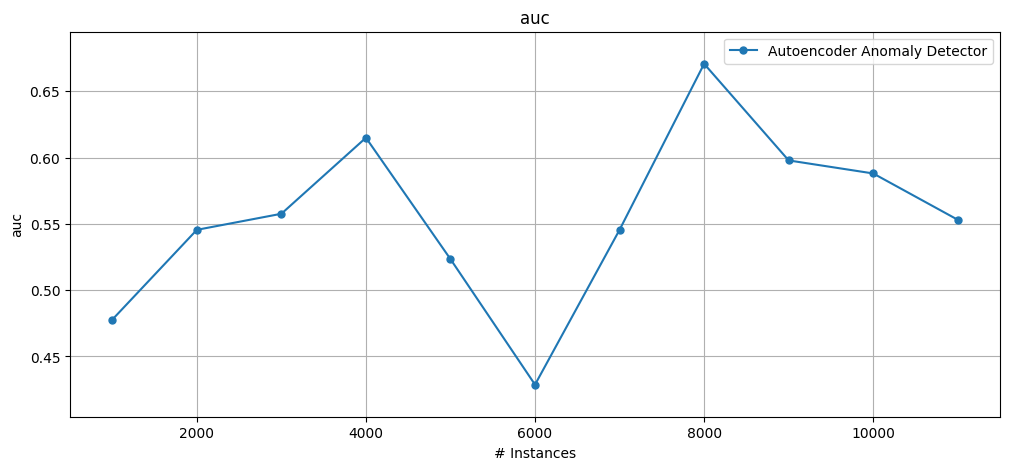

In [4]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import Autoencoder
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
ae = Autoencoder(schema=stream_ad.get_schema(), hidden_layer=1)

results_ae = prequential_evaluation_anomaly(
    stream=stream_ad, learner=ae, window_size=1000
)

print(f"AUC: {results_ae.auc()}")
display(results_ae.windowed.metrics_per_window())
plot_windowed_results(results_ae, metric="auc", save_only=False)

## 3.3 Online Isolation Forest

AUC: 0.643632


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.609091,0.111064,0.959,0.031649,0.000000,0.010101,0.311075,0.1,-3.100000
1,2000.0,0.767228,0.063018,0.993,0.000000,0.609091,0.007049,0.000000,0.0,0.176471
2,3000.0,0.678463,0.060250,0.986,0.000000,0.767228,0.014199,0.000000,0.0,-0.354839
3,4000.0,0.680835,0.083064,0.994,0.000000,0.678463,0.006036,0.000000,0.0,0.351351
4,5000.0,0.632560,0.057094,0.992,0.000000,0.680835,0.008065,0.000000,0.0,0.111111
5,6000.0,0.632492,0.085781,0.987,0.000000,0.632560,0.013171,0.000000,0.0,-0.344828
6,7000.0,0.585457,0.043215,0.987,0.000000,0.632492,0.013171,0.000000,0.0,-0.281690
7,8000.0,0.789848,0.082476,0.990,0.000000,0.585457,0.010101,0.000000,0.0,0.012346
8,9000.0,0.675025,0.069445,0.992,0.000000,0.789848,0.008065,0.000000,0.0,0.191011
9,10000.0,0.649849,0.066430,0.991,0.000000,0.675025,0.009082,0.000000,0.0,0.081633


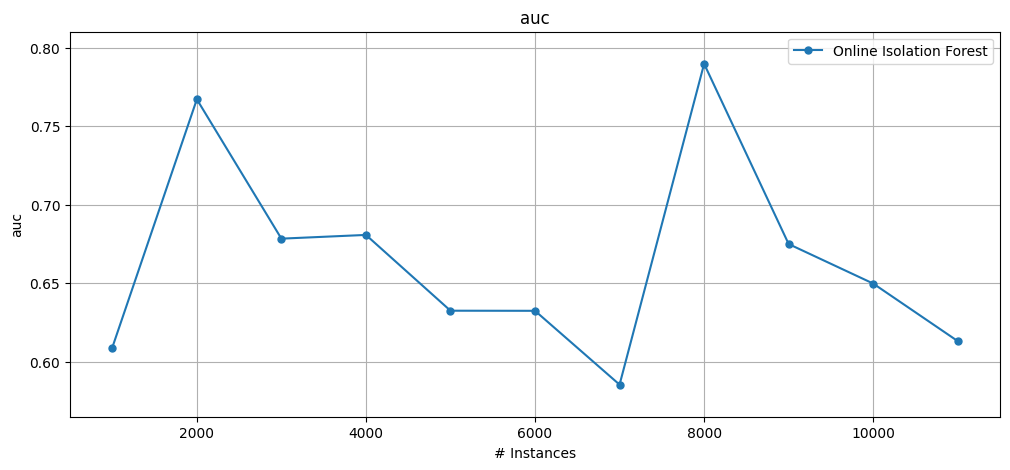

In [5]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
oif = OnlineIsolationForest(schema=stream_ad.get_schema(), num_trees=10)

results_oif = prequential_evaluation_anomaly(
    stream=stream_ad, learner=oif, window_size=1000
)

print(f"AUC: {results_oif.auc()}")
display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## 4 Comparing algorithms

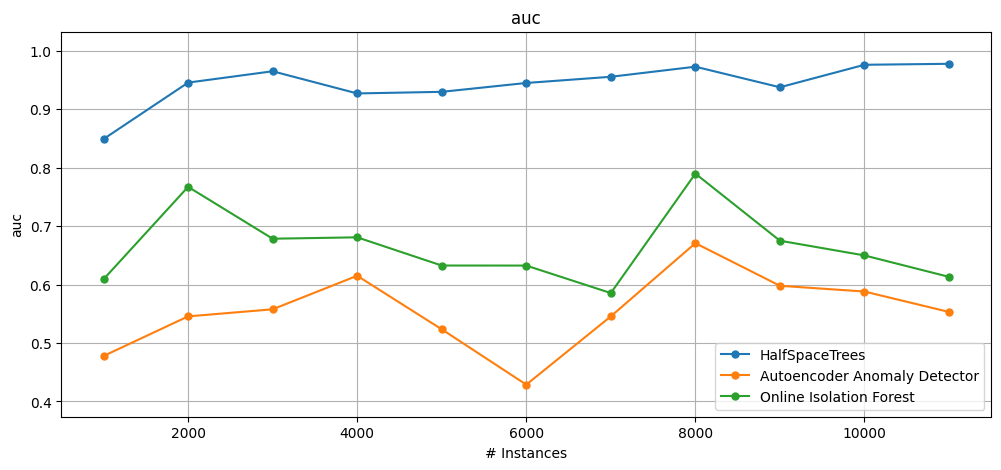

In [6]:
plot_windowed_results(
    results_hst, results_ae, results_oif, metric="auc", save_only=False
)